# Grad-CAM
This example interactively demonstrates Grad-CAM using nnabla's pre-trained model.

[Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, Dhruv Batra. Grad-CAM: Visual explanations from deep networks via gradient-based localization. Proceedings of the IEEE International conference on computer vision, pages 618 - 626, 2017.](https://openaccess.thecvf.com/content_iccv_2017/html/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.html)

Where does machine learning look at images to make decisions? This paper describes Grad-CAM, an algorithm that uses heat maps to indicate the image areas used as the basis for judgment in image classification by CNN [R.R. Selvaraju + 2016]. The principle behind Grad-CAM is to visualize the information on which the decision is based by displaying the location of the large input gradient to the final convolution layer. Grad-CAM allows you to visualize areas of relevance for each prediction class. In the final output, the gradient is backpropagated, with only the specified class being 1 and the other classes being 0, to find the gradient in the feature map. Uses the average slope on each channel as a weight, and adds that weight to the values in the feature map. The Grad-CAM is computed through the activation function ReLU to remove the negative part. The feature is that the operation is very light, so it can be operated at high speed. As an example of application, we can see where the misclassified images were judged. It can also detect cases where misclassification occurs due to gender differences.

![Grad-CAM algorithm](https://github.com/sony/nnabla-examples/raw/master/responsible_ai/gradcam/images/grad-cam_fig.png)

# Preparation
Let's start by installing nnabla and accessing [nnabla-examples repository](https://github.com/sony/nnabla-examples). If you're running on Colab, make sure that your Runtime setting is set as GPU, which can be set up from the top menu (Runtime → change runtime type), and make sure to click **Connect** on the top right-hand side of the screen before you start.

Import dependencies

In [3]:
import os
import cv2
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import nnabla as nn
from nnabla.utils.image_utils import imread
from nnabla.models.imagenet import VGG16

from gradcam import gradcam
from gradcam import overlay_images

#from nnabla.ext_utils import get_extension_context
#ctx = get_extension_context('cudnn')
#nn.set_default_context(ctx)

## Image Preparation 
Download image to apply Grad-CAM for.

In [4]:
url = 'https://upload.wikimedia.org/wikipedia/commons/4/4e/A_crab_spider_on_a_flower_preying_upon_a_euglossine_bee%2C_while_a_butterfly_looks_for_nectar.jpg'
img_path = 'input_flower_moth_spider.jpg'
if not os.path.isfile(img_path):
    tgt = urllib.request.urlopen(url).read()
    with open(img_path, mode='wb') as f:
        f.write(tgt)

Take a look at what the image looks like.  
We can see a flower in the middle on which a butterfly rests.

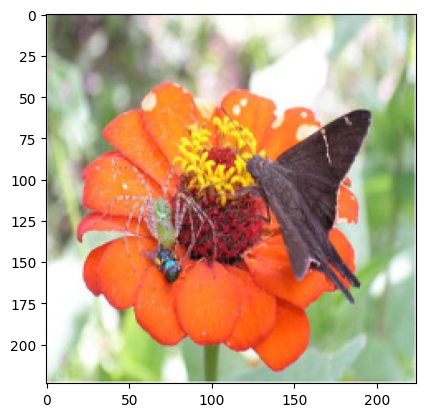

In [5]:
img = imread(img_path, size=(224, 224), channel_first=True)
plt.imshow(img.transpose(1,2,0))
plt.show()

## Network Definition
Loading the model is very simple.<br>
You can choose other models such as `VGG11`, `VGG13`, by specifying the model's name as an argument. Of course, you can choose other pretrained models as well. See the [Docs](https://nnabla.readthedocs.io/en/latest/python/api/models/imagenet.html).

**NOTE**: If you use the `VGG16` for the first time, nnabla will automatically download the weights from `https://nnabla.org` and it may take up to a few minutes.

In [6]:
model = VGG16()

2023-02-12 09:35:41,767 [nnabla][INFO]: Downloading VGG-16.nnp from https://nnabla.org/pretrained-models/nnp_models/imagenet/VGG-16/VGG-16.nnp
VGG-16.nnp: 100%|██████████| 528M/528M [01:17<00:00, 7.15MB/s] 


Loading /home/vscode/nnabla_data/nnp_models/imagenet/VGG-16.nnp.


In [7]:
batch_size = 1
x = nn.Variable((batch_size,) + model.input_shape)
# set training True since gradient of variable is necessary for Grad-CAM
vgg = model(x, training=True, returns_net=True)
vgg_variables = vgg.variables

We now define the input, and extract the necessary outputs.  
middle_layer: the last convolution layer  
pred: final output of the model

In [8]:
target_label_indices = {
    'butterfly': 326,# lycaenid, lycaenid butterfly
    'flower': 985,# daisy
    'spider': 74,# garden spider
}

input_name = list(vgg.inputs.keys())[0]
vgg_variables[input_name].d = img
middle_layer = vgg_variables['VGG16/ReLU_13']
pred = vgg_variables["VGG16/Affine_3"]
selected = pred[:, target_label_indices['butterfly']]

Let's see how the model predicted the image.  
We can see the model classified the image as we expect.  
Labels regarding butterfly comes high, while flower is also recognized although it is14th ranked probability.

In [9]:
selected.forward()

In [10]:
predicted_labels = np.argsort(-pred.d[0])
for i, predicted_label in enumerate(predicted_labels[:15]):
        print(f'Top {i+1}, Label index: {predicted_label},  Label name: {model.category_names[predicted_label]}')

Top 1, Label index: 326,  Label name: lycaenid, lycaenid butterfly
Top 2, Label index: 716,  Label name: picket fence, paling
Top 3, Label index: 318,  Label name: lacewing, lacewing fly
Top 4, Label index: 321,  Label name: admiral
Top 5, Label index: 325,  Label name: sulphur butterfly, sulfur butterfly
Top 6, Label index: 323,  Label name: monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
Top 7, Label index: 322,  Label name: ringlet, ringlet butterfly
Top 8, Label index: 658,  Label name: mitten
Top 9, Label index: 953,  Label name: pineapple, ananas
Top 10, Label index: 94,  Label name: hummingbird
Top 11, Label index: 319,  Label name: dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk
Top 12, Label index: 310,  Label name: ant, emmet, pismire
Top 13, Label index: 309,  Label name: bee
Top 14, Label index: 985,  Label name: daisy
Top 15, Label index: 904,  Label name: window screen


## Grad-CAM Computation

Execute backward computation to calculate gradient to use for Grad-CAM.

In [11]:
selected.backward()

Let's compute the heatmap using the gradient with respect to the last convolution layer.

In [12]:
heatmap = gradcam(middle_layer)

## Visualization
Take a look at how the heatmap looks like in the layer of interest.

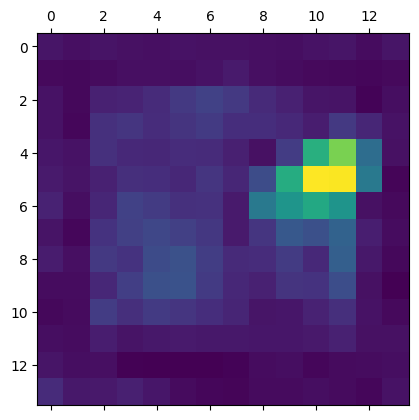

In [13]:
plt.matshow(heatmap)
plt.show()

Then we overlay the heatmap onto the original image to understand where the model focused.

In [14]:
base_img = imread(img_path, size=(224, 224))
overlaid_img_butterfly = overlay_images(base_img, heatmap)

Now we overlay the heatmap onto the original image to understand where the model focused.  
We can speculate the model recognized the butterfly, focusing on its wing.

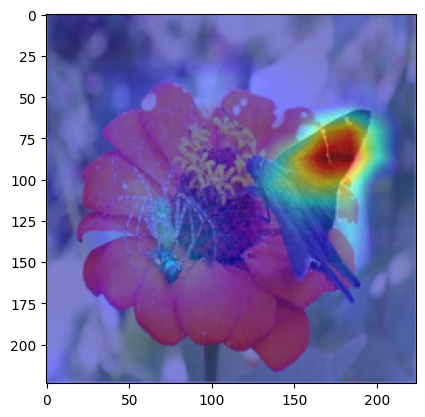

In [15]:
plt.imshow(overlaid_img_butterfly)
plt.show()

Let's use flower as the label of interest to see how the model see the image this time by calculating Grad-CAM.

Reset gradient first.

In [16]:
for k, v in vgg_variables.items():
    if 'VGG16/' in k:
        v.grad.zero()

Calculate gradient and Grad-CAM same as for butterfly.

In [17]:
selected_daisy = pred[:, target_label_indices['flower']]
selected_daisy.backward()

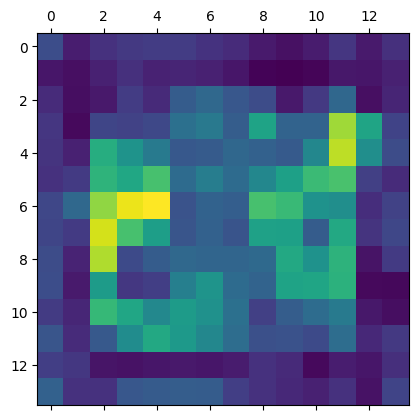

In [18]:
heatmap_daisy = gradcam(middle_layer)
plt.matshow(heatmap_daisy)
plt.show()

We can see the model focus is widely spread comparing to than for butterfly as if the heatmap wrapped the flower. 

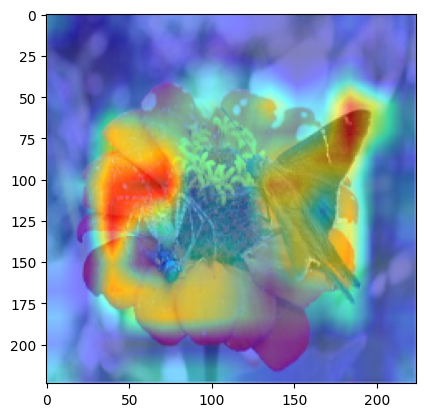

In [19]:
overlaid_img_daisy = overlay_images(base_img, heatmap_daisy)
plt.imshow(overlaid_img_daisy)
plt.show()

Finally, compare images in oneline to enable to see the differences clearly.

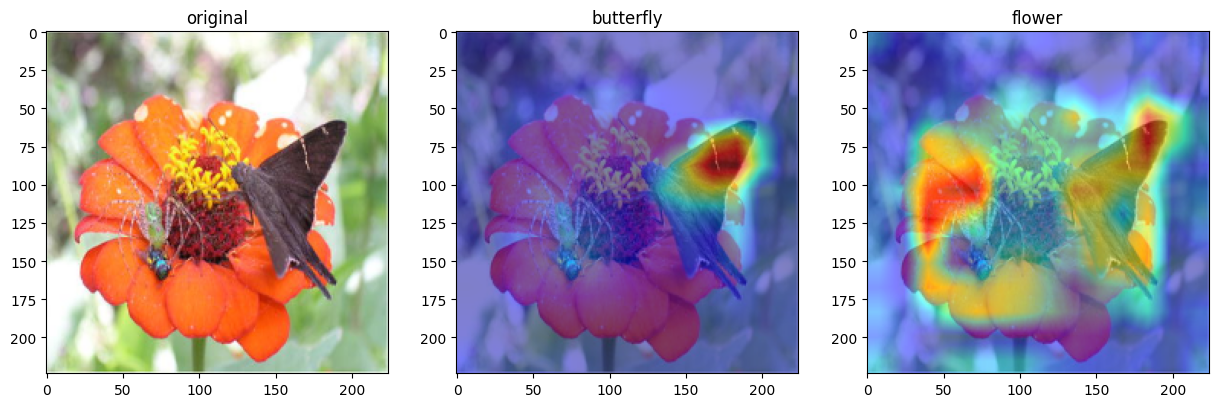

In [20]:
images = {
    'original': base_img,
    'butterfly': overlaid_img_butterfly,
    'flower': overlaid_img_daisy,
}


row = 1
col = len(images)
fig, axes = plt.subplots(row, col, figsize=(15,15))

for i, (k, v) in enumerate(images.items()):
    axes[i].imshow(v)
    axes[i].set_title(k)